In [176]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [177]:
from torch import nn

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.linear2 = nn.Linear(512, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512, 40)
        self.drop = nn.Dropout(p=0.3)
        self.act = nn.ReLU()

    # forward 前向运算 (nn.Module方法重写)
    def forward(self, input_tensor):
        out = self.linear1(input_tensor)
        out = self.bn1(out)
        out = self.act(out)
        out = self.drop(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out = self.act(out)
        out = self.drop(out)
        final = self.linear3(out) # shape

        return final

In [178]:
model = TorchNN().to(device=device)
input_data = torch.randn((10, 4096)).to(device=device)
final = model(input_data)
print(final.shape)

torch.Size([10, 40])


In [179]:
import sklearn.datasets as datasets

data = datasets.fetch_olivetti_faces(data_home='./olivetti', shuffle=True)

[ name for name in data]

['data', 'images', 'target', 'DESCR']

In [180]:
data.data.shape, data.images.shape, data.target.shape, type(data.DESCR)

((400, 4096), (400, 64, 64), (400,), str)

In [181]:
set(data.target)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39}

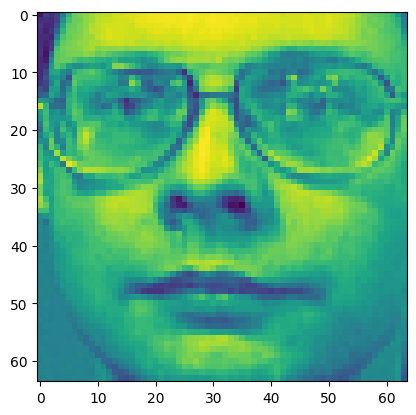

In [182]:
import matplotlib.pyplot as plot

plot.imshow(data.images[10])
plot.show()

In [183]:
# 分割list
def split_data(data, test_size):
    train_size = len(data) - test_size
    return torch.utils.data.random_split(data, [train_size,test_size])
# 转化为张量
def to_tensor(data, device=device):
    print(device)
    return torch.tensor(data).to(device=device)
# 转化为DataLoader
def to_dataloader(data, batch_size):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
# 分割数据集并转为DataLoader
def to_dataloaders(data, target, batch_size, test_size):
    dataset = [(features,label) for features,label in zip(to_tensor(data), to_tensor(target))]
    print(len(dataset))
    train_dataset,test_dataset = split_data(dataset, test_size)
    return to_dataloader(train_dataset, batch_size),to_dataloader(test_dataset, batch_size)
    

In [184]:
# 定义超参数
LR = 1e-3
EPOCH = 25
BATCH_SIZE = 128
TEST_SIZE = 100
dataloader, test_dl = to_dataloaders(data.data, data.target, BATCH_SIZE, TEST_SIZE)
# 损失函数&优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数
# 优化器（模型参数更新）
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

cuda
cuda
400


In [185]:
# 正则化&归一化生效
model.train()
for epoch in range(EPOCH):
    # 提取训练数据
    for data, target in dataloader:
        # 前向运算
        output = model(data)
        # 计算损失
        loss = loss_fn(output, target)
        # 反向传播
        model.zero_grad()  # 所有参数梯度清零
        loss.backward()     # 计算梯度（参数.grad）
        optimizer.step()    # 更新参数

    print(f'Epoch:{epoch} Loss: {loss.item()}')

Epoch:0 Loss: 2.902526617050171
Epoch:1 Loss: 1.8182872533798218
Epoch:2 Loss: 1.4405163526535034
Epoch:3 Loss: 1.0666662454605103
Epoch:4 Loss: 0.874888002872467
Epoch:5 Loss: 0.6389216780662537
Epoch:6 Loss: 0.6026172041893005
Epoch:7 Loss: 0.4669911563396454
Epoch:8 Loss: 0.3263683021068573
Epoch:9 Loss: 0.19934597611427307
Epoch:10 Loss: 0.17899753153324127
Epoch:11 Loss: 0.1191139668226242
Epoch:12 Loss: 0.10633237659931183
Epoch:13 Loss: 0.09714005142450333
Epoch:14 Loss: 0.07577458024024963
Epoch:15 Loss: 0.05055093392729759
Epoch:16 Loss: 0.07276623696088791
Epoch:17 Loss: 0.06680154800415039
Epoch:18 Loss: 0.056742582470178604
Epoch:19 Loss: 0.04151182249188423
Epoch:20 Loss: 0.03778223320841789
Epoch:21 Loss: 0.049531128257513046
Epoch:22 Loss: 0.0320177897810936
Epoch:23 Loss: 0.026100944727659225
Epoch:24 Loss: 0.02780197374522686


In [186]:
# 测试

correct = 0
total = 0
model.eval() # train(False)
with torch.no_grad():  # 不计算梯度
    for data, target in test_dl:
        output = model(data)
        _, predicted = torch.max(output, 1)  # 返回每行最大值和索引
        total += target.size(0)  # size(0) 等效 shape[0]
        correct += (predicted == target).sum().item()

print(f'Accuracy: {correct} / {total} = {correct/total*100}%')

Accuracy: 97 / 100 = 97.0%
